# Marrying Grounding DINO with Stable Diffusion for Image Editing


[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO)
[![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) 
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wxWDt5UiwY8)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)
[![HuggingFace space](https://img.shields.io/badge/🤗-HuggingFace%20Space-cyan.svg)](https://huggingface.co/spaces/ShilongLiu/Grounding_DINO_demo)

![gdsd](https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/gdsd_example.png)

# Install diffusers 

In [50]:
! pip install diffusers transformers accelerate scipy safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")


import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download


# Load grounding dino models

In [3]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model    

In [4]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"

In [5]:
model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/liushilong/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/4d4409dc29f29629f4ebb808a68ea67be53886b6/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


# Load stable diffusion inpainting models

In [34]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 44656.80it/s]


# Load demo image

In [10]:
image_url = 'https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/cats.png'
local_image_path = 'cats.png'

In [11]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

download_image(image_url, local_image_path)

Image downloaded from url: https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/cats.png and saved to: cats.png.


# Run Grounding DINO

In [131]:
import os
import supervision as sv


TEXT_PROMPT = "the black cat ."
BOX_TRESHOLD = 0.45
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

# image_source: np.ndarray
# annotated_frame: np.ndarray

In [132]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [133]:
image_mask = generate_masks_with_grounding(image_source, boxes)

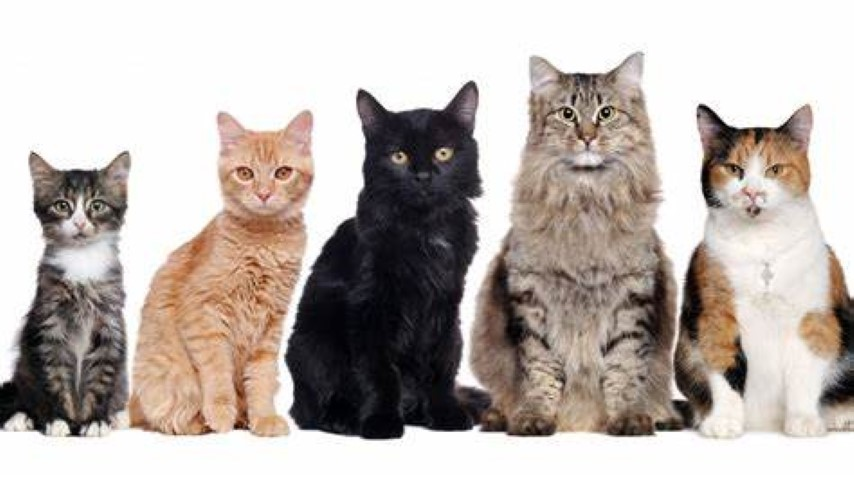

In [134]:
Image.fromarray(image_source)

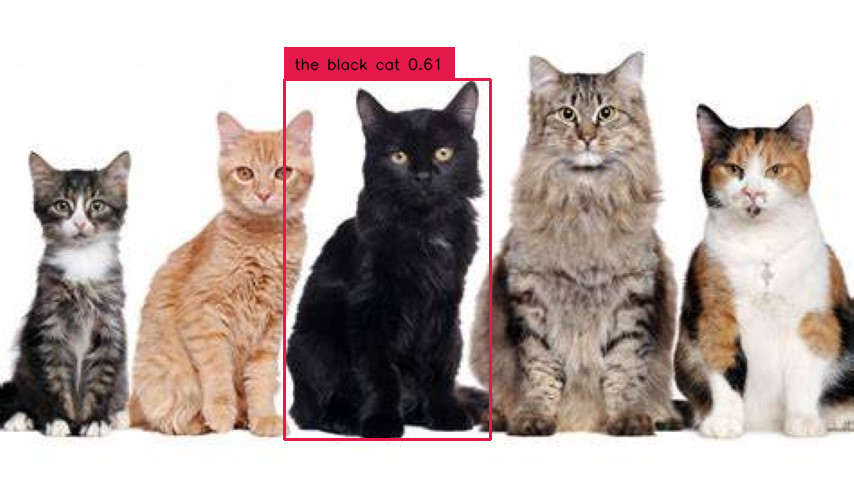

In [135]:
Image.fromarray(annotated_frame)

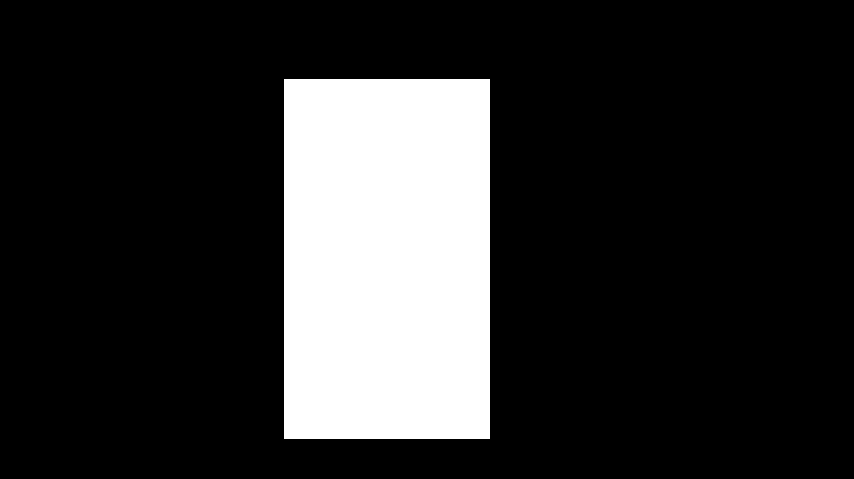

In [136]:
Image.fromarray(image_mask)

In [137]:
# image_source

# Image Inpainting

In [19]:
image_source = Image.fromarray(image_source)
annotated_frame = Image.fromarray(annotated_frame)
image_mask = Image.fromarray(image_mask)

In [20]:
image_source_for_inpaint = image_source.resize((512, 512))
image_mask_for_inpaint = image_mask.resize((512, 512))

In [44]:
prompt = "a cute dinosaur"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

100%|██████████| 50/50 [00:02<00:00, 22.20it/s]


In [45]:
image_inpainting = image_inpainting.resize((image_source.size[0], image_source.size[1]))

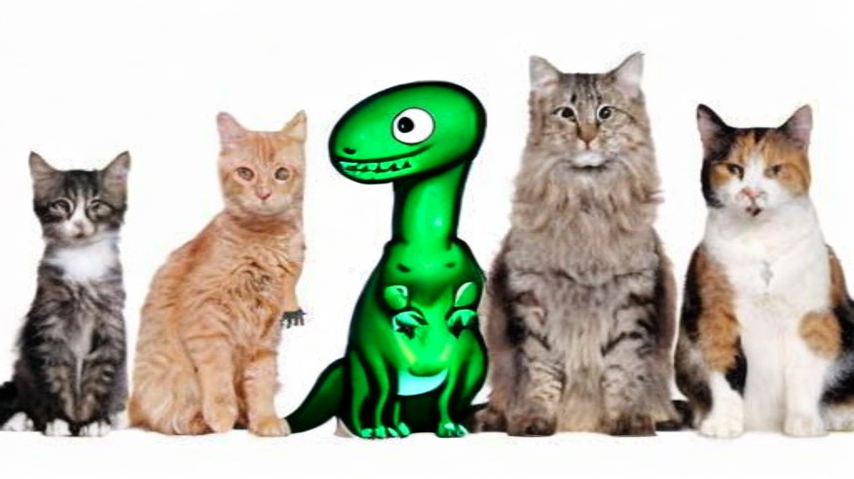

In [46]:
image_inpainting